In [9]:
import pandas as pd
from kan.custom_utils import (plot_data_per_interval,
                              plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures")
time_stamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')

fn = "fastperiodic_sin(2x0)+5x1_20251023_1152"
ground_truth = lambda x0, x1: np.sin(2*x0) + 5*x1
save_tag = 'fastperiodic_' + fn
save_heading = os.path.join(save_dir, save_tag)

df = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', fn + ".xlsx"), sheet_name='best_avg_by_params')
d_opt = df

This script is running on cpu.


| train_loss: 4.34e-03 | test_loss: 4.65e-03 | reg: 2.96e+00 | : 100%|█| 50/50 [00:15<00:00,  3.22it


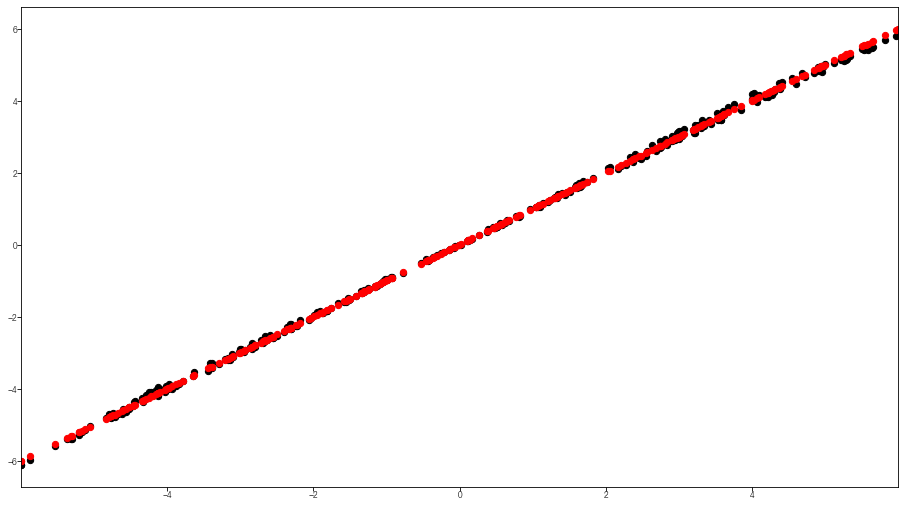

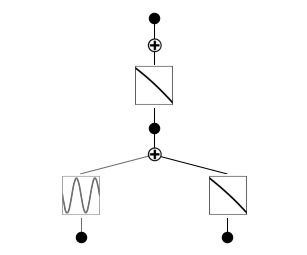

TrialResult(params={'grid': 30, 'k': 3, 'lamb': 0.0001, 'lamb_coef': 1, 'lamb_entropy': 1, 'lr': 5, 'mult_arity': 0, 'opt': 'LBFGS', 'prune': True, 'pruning_edge_th': 0.03, 'pruning_node_th': 0.01, 'steps': 50, 'sym_a_range': '[-20, 20]', 'sym_weight_simple': 0.5, 'symbolic': False, 'update_grid': True, 'width': [[2, 0], [2, 0], [1, 0]]}, val_loss=0.05699165537953377, train_loss=0.049999818205833435, test_loss=0.055032115429639816, r2_train=0.9995362967631563, r2_val=0.9994910545233908, r2_test=0.9994959479847205, seed=0, device='cpu', spline_train_loss=0.04634561762213707, spline_test_loss=0.0498821958899498)


In [10]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.experiments.multkan_hparam_sweep import evaluate_params, _to_tensor, _build_dataset
from kan.utils import ex_round

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

x1_grid = np.linspace(-np.pi, np.pi, 60)
x2_grid = np.linspace(-1, 1, 30)

x1, x2= np.meshgrid(x1_grid, x2_grid)
X = np.stack((x1.flatten(), x2.flatten()), axis=1)

d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

y_mesh = ground_truth(x1, x2)
y = y_mesh.flatten().reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))
X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

params['symbolic'] = False
params['grid'] = 30

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm,
    0, scaler_y, device.type,
    save_heading=save_heading
)
model.plot()
plt.show()
print(res)
with open(os.path.join(save_dir, f"{save_tag}_result.json"), 'w') as f:
    json.dump(vars(res), f, indent=4)

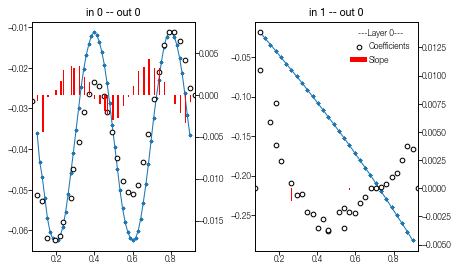

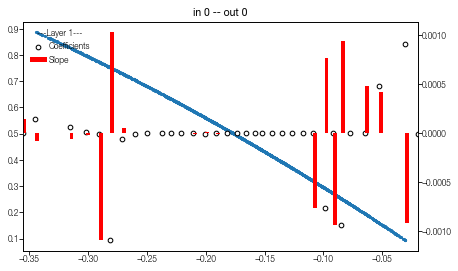

[<Figure size 450x262.5 with 4 Axes>, <Figure size 450x262.5 with 2 Axes>]

In [11]:
plot_activation_and_spline_coefficients(model, save_heading=save_heading, x=dataset, layers=None)

In [12]:
print(f"Original symbolic weight_simple: {params['sym_weight_simple']}")

model.suggest_symbolic(0, 0, 0, weight_simple=params['sym_weight_simple'], a_range=(-20, 20))

Original symbolic weight_simple: 0.5
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      sin    0.999752 -11.922927           2                2   -4.961463
1      cos    0.999752 -11.922259           2                2   -4.961129
2        0    0.000000   0.000014           0                0    0.000007
3        x    0.124216  -0.191336           1                1    0.404332
4    1/x^2    0.134996  -0.209205           2                2    0.895397


('sin',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9997524619102478,
 2)

In [13]:
model.suggest_symbolic(0, 1, 0, weight_simple=params['sym_weight_simple'], a_range=(-20, 20))
model.suggest_symbolic(1, 0, 0, weight_simple=params['sym_weight_simple'], a_range=(-20, 20))

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    x^0.5    0.999995 -16.024025           2                2   -7.012013
1     sqrt    0.999995 -16.024025           2                2   -7.012013
2      log    0.999994 -15.887445           2                2   -6.943722
3      exp    0.999990 -15.630306           2                2   -6.815153
4      x^2    0.999982 -15.124183           2                2   -6.562091
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      x^2    1.000000 -16.644454           2                2   -7.322227
1      cos    0.999998 -16.386968           2                2   -7.193484
2      sin    0.999998 -16.386968           2                2   -7.193484
3      exp    0.999998 -16.379618           2                2   -7.189809
4      1/x    0.999995 -16.070610           2                2   -7.035305


('x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 1.000000238418579,
 2)

Best value at boundary.
r2 is 0.1944991648197174
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,0) with sin, r2=1.0, c=2
r2 is 0.9999951124191284
fixing (0,1,0) with sqrt, r2=1.0, c=2
r2 is 1.0000001192092896
fixing (1,0,0) with x^2, r2=1.0, c=2


| train_loss: 4.72e-03 | test_loss: 4.77e-03 | reg: 1.79e+00 | : 100%|█| 50/50 [00:14<00:00,  3.45it


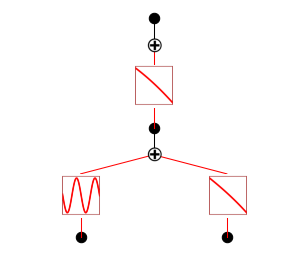

1.566 - 1.4285*(-sqrt(1 - 0.5719*x_2) - 0.027*sin(15.8083*x_1 - 11.0725) - 0.019)**2


In [14]:
lib = ['sin', 'cos', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', '1/x', '1/x^2']
sym_weight_simple = params.get('sym_weight_simple', 0.8)
sym_r2_threshold = params.get('sym_r2_threshold', 0.)
params['update_grid'] = ['False']

model.auto_symbolic(lib=lib,
                    weight_simple=sym_weight_simple, r2_threshold=sym_r2_threshold,
                    a_range=(-20, 20))
model.fit(dataset, **fit_kwargs)

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)
name_X = [f'x{idx}' for idx in range(X_norm.shape[1])]
name_y = ['y']
y_pred_norm = model(_to_tensor(X_norm, device)).detach().cpu().numpy()
y_pred = scaler_y.inverse_transform(y_pred_norm)

model.plot(beta=10)
plt.show()

sym_fun = ex_round(model.symbolic_formula()[0][0], 4)
print(sym_fun)

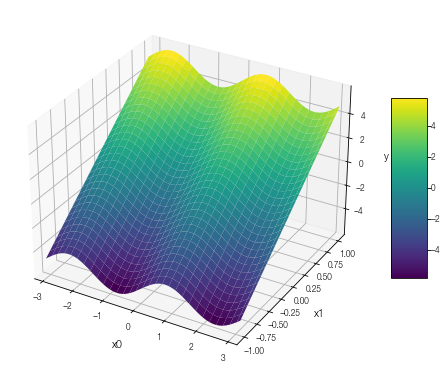

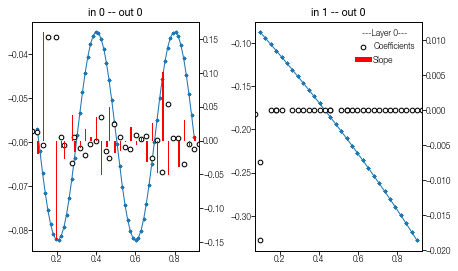

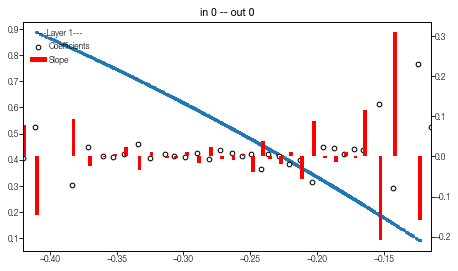

[<Figure size 450x262.5 with 4 Axes>, <Figure size 450x262.5 with 2 Axes>]

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x1, x2, y_mesh, cmap='viridis', edgecolor='none')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')
fig.colorbar(surface, shrink=0.5, aspect=5)
plt.savefig(os.path.join(save_dir, f"{save_tag}_ground_truth.png"))
plt.show()

plot_activation_and_spline_coefficients(model, save_heading=save_heading, x=dataset, layers=None)

## Raw Data Analysis

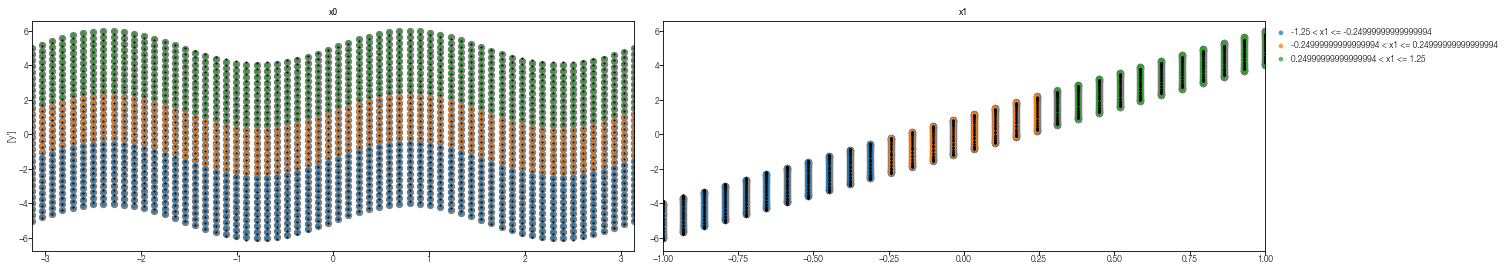

In [16]:
# mask_idx = 1
# mask_interval = [-1 + 0.5 * i for i in range(5)]
mask_idx = 1
# mask_interval = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
mask_scaled_interval = [0, 0.4, 0.6, 1]
mask_interval = [scaler_X.inverse_transform(np.array([[x0, x0]]))[0, mask_idx] for x0 in mask_scaled_interval]

fig_x1, ax_x1 = plot_data_per_interval(X, y, name_X, name_y, mask_idx, mask_interval)
plt.savefig(os.path.join(save_dir, f"{save_tag}_data_colored.png"))
for idx_x in range(X.shape[1]):
    ax_x1[idx_x].scatter(X[:, idx_x], y_pred, color='k', s=.9, label='Prediction')
plt.savefig(os.path.join(save_dir, f"{save_tag}_data_and_prediction.png"))
plt.show()

Fast periodic function 학습 완료!